# SOI1010 Machine Learning II - Assignment #2

The submission should include a code (both link to the colab and .py format) and a report that has answers to the questions and results. Use PyTorch (or TensorFlow/JAX). Also, minimize the use of numpy. There will be mark deductions if numpy is used when PyTorch is preferable or should be used. Marks will be deducted if the submission does not include the requested files. DO NOT use other libraries, such as scikit-learn/sklearn, to use a model (kNN in this case) you are supposed to implement. Using sklearn or any other third library or already built-in functions that you are asked to implement will result in 0 mark. So, please don’t ask “Can I use this library/numpy/etc.?” Also, if an assignment asks you to implement some model, that means you shouldn’t use the built-in implementation from any library for that model in the first place.

### Problem #1: Binary Classification via soft-margin SVM on CIFAR10

##### a) Load CIFAR10 dataset as follows:

In [62]:
import numpy as np
import torch
from torch.utils.data import random_split, DataLoader
from torch.autograd import Variable
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

device = (
    'cuda'
    if torch.cuda.is_available()
    else 'mps'
    if torch.backends.mps.is_available()
    else 'cpu'
)
print(f"Now using {device}")

trainset = datasets.CIFAR10(root='./data', train=True,
                            download=True, transform=transforms.ToTensor())
testset = datasets.CIFAR10(root='./data', train=False, 
                           download=True, transform=transforms.ToTensor())

Now using mps
Files already downloaded and verified
Files already downloaded and verified


##### b) Visualize at least one image for each class. You may need to look into how dataset is implemented in PyTorch.

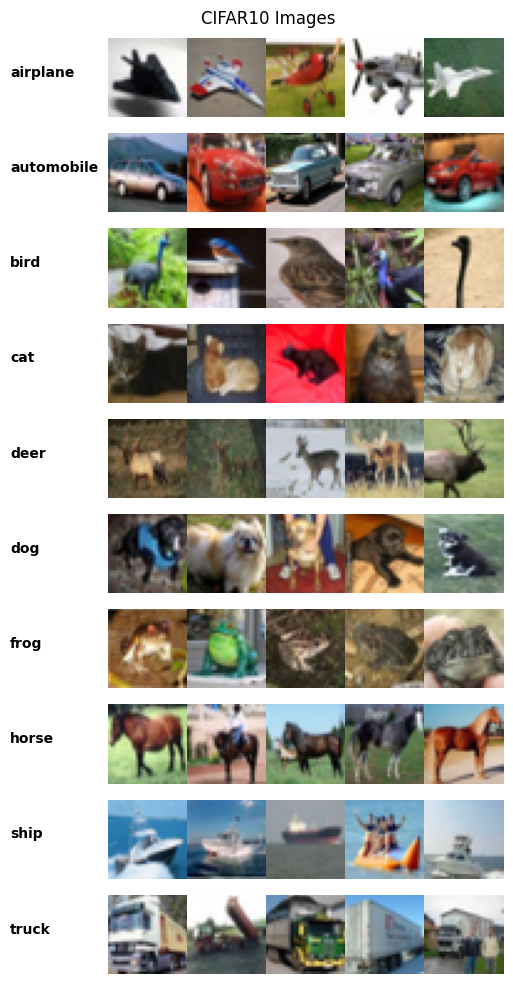

In [63]:
# Pick 5 sample data
labels_map = {j:i for (i,j) in trainset.class_to_idx.items()}
sample_data = {i : [] for i in range(10)}
for c in labels_map.keys():
    tmp = 0
    idx = 0
    while tmp < 5:
        if trainset[idx][1] == c:
            sample_data[c].append(trainset[idx][0].permute(1,2,0))
            tmp += 1
        idx += 1

# Plot
fig = plt.figure(figsize=(5, 10))
fig.suptitle('CIFAR10 Images')
gs = fig.add_gridspec(10, 5, wspace=0)
for row in range(10):
    for col in range(5):
        ax = fig.add_subplot(gs[row, col])
        ax.axis('off')
        ax.imshow(sample_data[row][col])
        ax.label_outer()
        if col == 0:
            ax.text(-40, 15, labels_map[row], horizontalalignment='left', weight='bold')
fig.tight_layout()
#plt.savefig('plot/fig1_Cifar10.png', dpi=200, bbox_inches='tight')

In [64]:
labels_map

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

##### c) Split the trainset into training set and validation set with 90% : 10% ratio. Implement dataloaders for CIFAR10.

In [65]:
traindata, validdata = random_split(trainset, [int(len(trainset)*.9), int(len(trainset)*.1)])

In [66]:
train_loader = DataLoader(traindata, batch_size=64, shuffle=True)
valid_loader = DataLoader(validdata, batch_size=64, shuffle=True)
print(f'''Train Data : {len(traindata)}
Valid Data : {len(validdata)}
''')

for x, y in train_loader:
    print(f"Shape of X [N, C, H, W]: {x.shape}")
    print(f"Shape of y: {y.shape}, {y.dtype}")
    break

Train Data : 45000
Valid Data : 5000

Shape of X [N, C, H, W]: torch.Size([64, 3, 32, 32])
Shape of y: torch.Size([64]), torch.int64


##### d) Choose any two classes. Then, make a SVM classifier.<br>Implement a loss function yourself. Do not use PyTorch implementations of loss functions.<br>And implement its training/validation/evaluation code to perform binary classification between those two classes.


In [67]:
# Choose two classes randomly
#classA, classB = np.random.choice(9, 2, replace=False)

# Choose two classes manually (3=cat, 5=dog)
classA, classB = 3, 5

# Filter them
traindata_filtered = []
for item in traindata:
    if item[1] == classA:
        traindata_filtered.append([item[0], 1])
    if item[1] == classB:
        traindata_filtered.append([item[0], -1])

validdata_filtered = []
for item in validdata:
    if item[1] == classA:
        validdata_filtered.append([item[0], 1])
    if item[1] == classB:
        validdata_filtered.append([item[0], -1])

print(f'''
class A : {labels_map[classA]}
class B : {labels_map[classB]}

{len(traindata_filtered)} data in train
{len(validdata_filtered)} data in valid
      ''')


class A : cat
class B : dog

9041 data in train
959 data in valid
      


In [68]:
# Hyperparameters
bs = 64
epochs = 10
learning_rate = 0.001
gamma = 1.0

In [69]:
# DataLoader for filtered data
train_floader = DataLoader(traindata_filtered, batch_size=bs, shuffle=True)
valid_floader = DataLoader(validdata_filtered, batch_size=bs, shuffle=True)

In [70]:
# Implement Model
from torch import nn

class SVM(nn.Module):
    def __init__(self, gamma=1.0):
        super(SVM, self).__init__()
        self.func = nn.Linear(3072, 1)
        self.gamma = gamma

    def forward(self, x):
        x = x.view(x.size(0), -1)
        fwd = self.func(x)
        return fwd

# Select Device
print(f"Now using {device} device\n")

Now using mps device



In [71]:
# Train
def train(dataloader, model, loss_fn, optimizer, epochs):
    hist = []
    for epoch in range(epochs):
        print(f"-------Epoch {epoch+1:2}-------")
        loss_ = 0
        for x, y in tqdm(dataloader, total=len(dataloader)):
            x, y = Variable(x).to(device), Variable(y).to(device)
            
            optimizer.zero_grad()
            yhat = model(x)
            loss = loss_fn(yhat, y) + torch.norm(model.func.weight) / (2 * model.gamma)
            loss.backward()
            optimizer.step()

            loss_ += loss.item()

        loss_ /= len(dataloader)
            
        print(f'Average Loss: {loss_:.5f}\n')
        hist.append(loss_)
    return hist

In [72]:
# Loss function : Hinge
def loss_fn(yhat, y):
    y = y.to(device)
    yhat = yhat.to(device)
    yhat = yhat.view(-1)
    loss = torch.clamp(1-y*yhat, min=0)
    return loss.mean()

In [73]:
# Model
model = SVM(gamma).to(device)

# Optimizer : Adam
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Model
print(model)

SVM(
  (func): Linear(in_features=3072, out_features=1, bias=True)
)


-------Epoch  1-------


100%|██████████| 142/142 [00:01<00:00, 115.55it/s]


Average Loss: 1.10386

-------Epoch  2-------


100%|██████████| 142/142 [00:00<00:00, 210.52it/s]


Average Loss: 1.00318

-------Epoch  3-------


100%|██████████| 142/142 [00:00<00:00, 227.31it/s]


Average Loss: 1.00125

-------Epoch  4-------


100%|██████████| 142/142 [00:00<00:00, 219.59it/s]


Average Loss: 1.01525

-------Epoch  5-------


100%|██████████| 142/142 [00:00<00:00, 221.71it/s]


Average Loss: 1.00803

-------Epoch  6-------


100%|██████████| 142/142 [00:00<00:00, 244.18it/s]


Average Loss: 0.99588

-------Epoch  7-------


100%|██████████| 142/142 [00:00<00:00, 254.95it/s]


Average Loss: 0.99998

-------Epoch  8-------


100%|██████████| 142/142 [00:00<00:00, 233.83it/s]


Average Loss: 1.00478

-------Epoch  9-------


100%|██████████| 142/142 [00:00<00:00, 236.80it/s]


Average Loss: 1.01077

-------Epoch 10-------


100%|██████████| 142/142 [00:00<00:00, 235.27it/s]


Average Loss: 1.00878



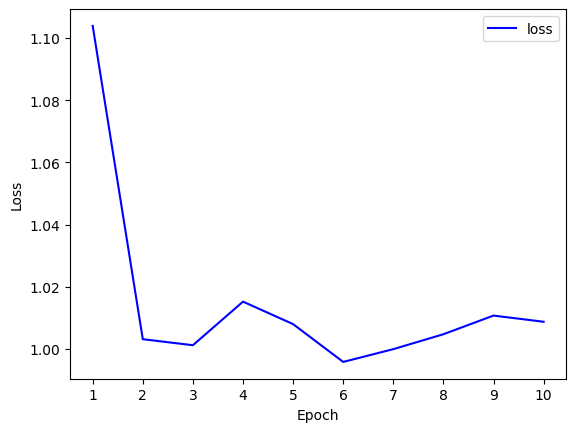

In [74]:
# Train Model
model.train()
hist1 = train(train_floader, model, loss_fn, optimizer, epochs)
plt.plot(range(1, epochs+1), hist1, 'b', label='loss')
plt.xticks(range(1, epochs+1))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig('plot/fig2_loss.png', dpi=200)

In [75]:
with torch.no_grad():  
    total_loss = 0
    model.eval()  
    correct = 0
    for x, y in valid_floader:  
        x = x.to(device)
        yhat = model(x).view(-1)
        yhat = yhat.to('cpu')
        loss = loss_fn(yhat, y) + torch.norm(model.func.weight) / (2 * model.gamma)
        yhat.apply_(lambda x: 1 if x>=0 else -1)
        correct += (yhat==y).sum()
        
        total_loss += loss.item()
    print(f"Accuracy : {100 * correct / len(valid_floader.dataset):.2f}%")
    print(f"Average Loss : {total_loss / len(valid_floader):.5f}")

Accuracy : 57.46%
Average Loss : 0.98996


In [76]:
def predict(data, model):
    with torch.no_grad():
        model.eval()
        data = data.view(1, -1).to(device)
        yhat = model(data)
        if yhat >= 0:
            return 1
        else:
            return -1

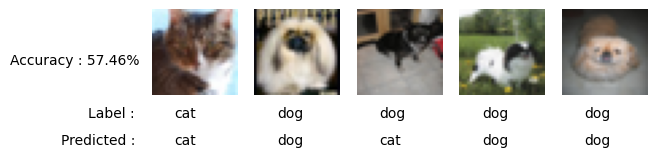

In [77]:
# Predict several data
pick_data = np.random.choice(len(validdata_filtered), 5, replace=False)
for i in range(5):
    plt.subplot(1,5,i+1)
    
    if i == 0:
        plt.text(-5, 40, "Label : ", horizontalalignment='right')
        plt.text(-5, 50, "Predicted : ", horizontalalignment='right')
        plt.text(-5, 20, f"Accuracy : {100 * correct / len(valid_floader.dataset):.2f}%", horizontalalignment='right')

    data = validdata_filtered[pick_data[i]]
    img = data[0]
    label = labels_map[classA] if data[1]==1 else labels_map[classB]
    pred = labels_map[classA] if predict(img, model)==1 else labels_map[classB]
    
    plt.imshow(img.permute(1,2,0))
    plt.text(8,40,label)
    plt.text(8,50,pred)
    plt.axis('off')
plt.savefig('plot/fig3_prediction.png', dpi=200, bbox_inches='tight')

##### f) Perform data normalization. You may need to look into how to use datasets in PyTorch.

In [78]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset_norm = datasets.CIFAR10(root='./data', train=True,
                            transform=transform)
testset_norm = datasets.CIFAR10(root='./data', train=False,
                            transform=transform)

traindata, validdata = random_split(trainset_norm, [int(len(trainset)*.9), int(len(trainset)*.1)])
train_loader = DataLoader(traindata, batch_size=bs)#, shuffle=True)
valid_loader = DataLoader(validdata, batch_size=bs)#, shuffle=True)
print(f'''Train Data : {len(traindata)}
Valid Data : {len(validdata)}
''')

for X, y in train_loader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape}, {y.dtype}")
    break

Train Data : 45000
Valid Data : 5000

Shape of X [N, C, H, W]: torch.Size([64, 3, 32, 32])
Shape of y: torch.Size([64]), torch.int64


In [79]:
# Choose two classes randomly
#classA, classB = np.random.choice(9, 2, replace=False)

# Choose two classes manually (3=cat, 5=dog)
classA, classB = 3, 5

# Filter them
traindata_filtered = []
for item in traindata:
    if item[1] == classA:
        traindata_filtered.append([item[0], 1])
    if item[1] == classB:
        traindata_filtered.append([item[0], -1])

validdata_filtered = []
for item in validdata:
    if item[1] == classA:
        validdata_filtered.append([item[0], 1])
    if item[1] == classB:
        validdata_filtered.append([item[0], -1])

# DataLoader for filtered data
train_floader = DataLoader(traindata_filtered, batch_size=bs)
valid_floader = DataLoader(validdata_filtered, batch_size=bs)

print(f'''
class A : {labels_map[classA]}
class B : {labels_map[classB]}

{len(traindata_filtered)} data in train
{len(validdata_filtered)} data in valid
      ''')


class A : cat
class B : dog

8986 data in train
1014 data in valid
      


##### g) Again, train for 10 epochs with batch size 64 after data normalization. Write down your observations.

-------Epoch  1-------


100%|██████████| 141/141 [00:00<00:00, 232.60it/s]


Average Loss: 1.06049

-------Epoch  2-------


100%|██████████| 141/141 [00:00<00:00, 243.66it/s]


Average Loss: 0.98557

-------Epoch  3-------


100%|██████████| 141/141 [00:00<00:00, 255.44it/s]


Average Loss: 0.98591

-------Epoch  4-------


100%|██████████| 141/141 [00:00<00:00, 219.54it/s]


Average Loss: 0.98519

-------Epoch  5-------


100%|██████████| 141/141 [00:00<00:00, 223.94it/s]


Average Loss: 0.98731

-------Epoch  6-------


100%|██████████| 141/141 [00:00<00:00, 198.71it/s]


Average Loss: 0.98406

-------Epoch  7-------


100%|██████████| 141/141 [00:00<00:00, 181.22it/s]


Average Loss: 0.98592

-------Epoch  8-------


100%|██████████| 141/141 [00:00<00:00, 239.15it/s]


Average Loss: 0.98590

-------Epoch  9-------


100%|██████████| 141/141 [00:00<00:00, 204.51it/s]


Average Loss: 0.98433

-------Epoch 10-------


100%|██████████| 141/141 [00:00<00:00, 221.52it/s]


Average Loss: 0.98560



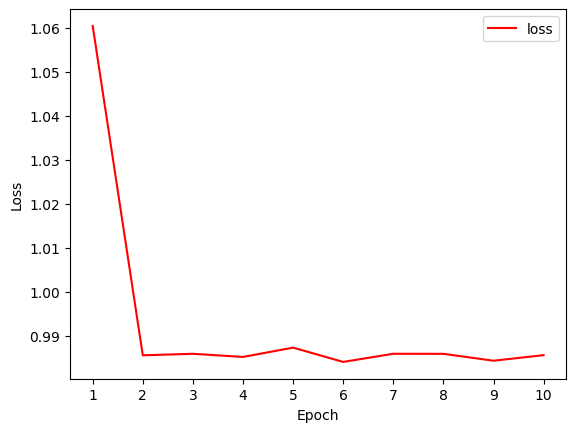

In [82]:
# Model
model = SVM(gamma).to(device)
# Optimizer : Adam
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# Train Model
model.train()
hist2 = train(train_floader, model, loss_fn, optimizer, epochs)
plt.plot(range(1, epochs+1), hist2, 'r', label='loss')
plt.xticks(range(1, epochs+1))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig('plot/fig4_loss.png', dpi=200, bbox_inches='tight')

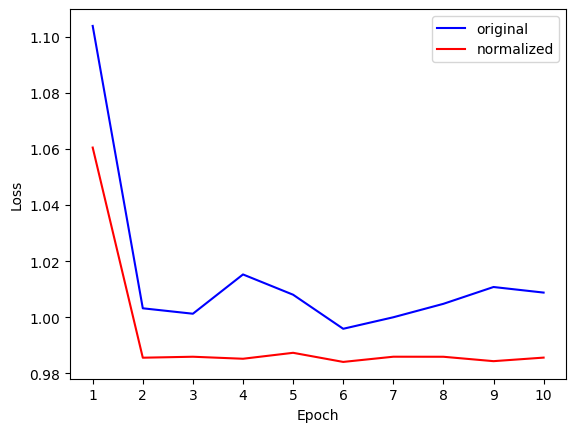

In [83]:
# Comparison
plt.plot(range(1, epochs+1), hist1, 'b', label='original')
plt.plot(range(1, epochs+1), hist2, 'r', label='normalized')
plt.xticks(range(1, epochs+1))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig('plot/fig5_comparison.png', dpi=200, bbox_inches='tight')

In [84]:
def evaluation(model, val_dataloader):
    with torch.no_grad():  
        total_loss = 0
        model.eval()  
        correct = 0
        for x, y in val_dataloader:  
            x, y = Variable(x).to(device), Variable(y).to(device)
            yhat = model(x).view(-1)
            loss = loss_fn(yhat, y) + torch.norm(model.func.weight) / (2 * model.gamma)
            yhat = torch.where(yhat<0, -1, 1)
            correct += (yhat==y).sum()
            
            total_loss += loss.item()
        
        final_accuracy = 100 * correct / len(val_dataloader.dataset)
        final_loss = total_loss / len(val_dataloader)

        return final_accuracy, final_loss

acc, los = evaluation(model, valid_floader)

print(f"Accuracy : {acc:.2f}%")
print(f"Average Loss : {los:.5f}")

Accuracy : 58.48%
Average Loss : 0.95664


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


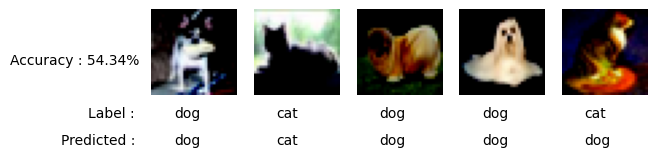

In [85]:
# Predict several data
pick_data = np.random.choice(len(validdata_filtered), 5, replace=False)
for i in range(5):
    plt.subplot(1,5,i+1)
    
    if i == 0:
        plt.text(-5, 40, "Label : ", horizontalalignment='right')
        plt.text(-5, 50, "Predicted : ", horizontalalignment='right')
        plt.text(-5, 20, f"Accuracy : {100 * correct / len(valid_floader.dataset):.2f}%", horizontalalignment='right')

    data = validdata_filtered[pick_data[i]]
    img = data[0]
    label = labels_map[classA] if data[1]==1 else labels_map[classB]
    pred = labels_map[classA] if predict(img, model)==1 else labels_map[classB]
    
    plt.imshow(img.permute(1,2,0))
    plt.text(8,40,label)
    plt.text(8,50,pred)
    plt.axis('off')

##### i) Try to obtain find optimal hyperparameters.

In [90]:
# Grid Search for optimal hyperparameters
def gridSearch(lr_, gamma_, epoch_):
    lst = []
    for gamma__ in gamma_:
        for lr__ in lr_:
            for epoch__ in epoch_:
                model = SVM(gamma__).to(device)
                optimizer = torch.optim.Adam(model.parameters(), lr=lr__)
                
                model.train()
                train(train_floader, model, loss_fn, optimizer, epoch__)
                acc, los = evaluation(model, valid_floader)
                lst.append([lr__, gamma__, epoch__, acc, los])
    return lst
                

In [92]:
lr_list = [0.001, 0.01, 0.1]
gamma_list = [0.1, 1.0, 10, 20]
epoch_list = [5, 10, 20, 50, 100]

grid = gridSearch(lr_list, gamma_list, epoch_list)

max_accuracy = max(grid, key=lambda x: x[3])
min_loss = min(grid, key=lambda x: x[4])

-------Epoch  1-------


100%|██████████| 141/141 [00:00<00:00, 222.39it/s]


Average Loss: 1.29574

-------Epoch  2-------


100%|██████████| 141/141 [00:00<00:00, 225.39it/s]


Average Loss: 1.07199

-------Epoch  3-------


100%|██████████| 141/141 [00:00<00:00, 235.16it/s]


Average Loss: 1.07154

-------Epoch  4-------


100%|██████████| 141/141 [00:00<00:00, 247.20it/s]


Average Loss: 1.07121

-------Epoch  5-------


100%|██████████| 141/141 [00:00<00:00, 228.79it/s]


Average Loss: 1.07096

-------Epoch  1-------


100%|██████████| 141/141 [00:00<00:00, 203.89it/s]


Average Loss: 1.29302

-------Epoch  2-------


100%|██████████| 141/141 [00:00<00:00, 206.77it/s]


Average Loss: 1.07193

-------Epoch  3-------


100%|██████████| 141/141 [00:00<00:00, 238.61it/s]


Average Loss: 1.07151

-------Epoch  4-------


100%|██████████| 141/141 [00:00<00:00, 241.75it/s]


Average Loss: 1.07118

-------Epoch  5-------


100%|██████████| 141/141 [00:00<00:00, 244.97it/s]


Average Loss: 1.07094

-------Epoch  6-------


100%|██████████| 141/141 [00:00<00:00, 216.43it/s]


Average Loss: 1.07075

-------Epoch  7-------


100%|██████████| 141/141 [00:00<00:00, 231.69it/s]


Average Loss: 1.07061

-------Epoch  8-------


100%|██████████| 141/141 [00:00<00:00, 250.22it/s]


Average Loss: 1.07068

-------Epoch  9-------


100%|██████████| 141/141 [00:00<00:00, 204.25it/s]


Average Loss: 1.07060

-------Epoch 10-------


100%|██████████| 141/141 [00:00<00:00, 232.96it/s]


Average Loss: 1.07053

-------Epoch  1-------


100%|██████████| 141/141 [00:00<00:00, 214.39it/s]


Average Loss: 1.29049

-------Epoch  2-------


100%|██████████| 141/141 [00:00<00:00, 252.58it/s]


Average Loss: 1.07198

-------Epoch  3-------


100%|██████████| 141/141 [00:00<00:00, 257.23it/s]


Average Loss: 1.07151

-------Epoch  4-------


100%|██████████| 141/141 [00:00<00:00, 209.09it/s]


Average Loss: 1.07118

-------Epoch  5-------


100%|██████████| 141/141 [00:00<00:00, 197.55it/s]


Average Loss: 1.07093

-------Epoch  6-------


100%|██████████| 141/141 [00:00<00:00, 218.55it/s]


Average Loss: 1.07074

-------Epoch  7-------


100%|██████████| 141/141 [00:00<00:00, 240.02it/s]


Average Loss: 1.07078

-------Epoch  8-------


100%|██████████| 141/141 [00:00<00:00, 220.69it/s]


Average Loss: 1.07068

-------Epoch  9-------


100%|██████████| 141/141 [00:00<00:00, 220.21it/s]


Average Loss: 1.07060

-------Epoch 10-------


100%|██████████| 141/141 [00:00<00:00, 191.04it/s]


Average Loss: 1.07053

-------Epoch 11-------


100%|██████████| 141/141 [00:00<00:00, 216.14it/s]


Average Loss: 1.07047

-------Epoch 12-------


100%|██████████| 141/141 [00:00<00:00, 204.61it/s]


Average Loss: 1.07042

-------Epoch 13-------


100%|██████████| 141/141 [00:00<00:00, 179.72it/s]


Average Loss: 1.07037

-------Epoch 14-------


100%|██████████| 141/141 [00:00<00:00, 206.32it/s]


Average Loss: 1.07034

-------Epoch 15-------


100%|██████████| 141/141 [00:00<00:00, 209.56it/s]


Average Loss: 1.07030

-------Epoch 16-------


100%|██████████| 141/141 [00:00<00:00, 194.87it/s]


Average Loss: 1.07027

-------Epoch 17-------


100%|██████████| 141/141 [00:00<00:00, 185.22it/s]


Average Loss: 1.07025

-------Epoch 18-------


100%|██████████| 141/141 [00:00<00:00, 212.01it/s]


Average Loss: 1.07022

-------Epoch 19-------


100%|██████████| 141/141 [00:00<00:00, 183.77it/s]


Average Loss: 1.07020

-------Epoch 20-------


100%|██████████| 141/141 [00:00<00:00, 230.22it/s]


Average Loss: 1.07018

-------Epoch  1-------


100%|██████████| 141/141 [00:00<00:00, 243.53it/s]


Average Loss: 1.29413

-------Epoch  2-------


100%|██████████| 141/141 [00:00<00:00, 235.90it/s]


Average Loss: 1.07201

-------Epoch  3-------


100%|██████████| 141/141 [00:00<00:00, 250.04it/s]


Average Loss: 1.07144

-------Epoch  4-------


100%|██████████| 141/141 [00:00<00:00, 250.54it/s]


Average Loss: 1.07122

-------Epoch  5-------


100%|██████████| 141/141 [00:00<00:00, 257.95it/s]


Average Loss: 1.07098

-------Epoch  6-------


100%|██████████| 141/141 [00:00<00:00, 247.03it/s]


Average Loss: 1.07080

-------Epoch  7-------


100%|██████████| 141/141 [00:00<00:00, 254.31it/s]


Average Loss: 1.07065

-------Epoch  8-------


100%|██████████| 141/141 [00:00<00:00, 252.48it/s]


Average Loss: 1.07053

-------Epoch  9-------


100%|██████████| 141/141 [00:00<00:00, 259.18it/s]


Average Loss: 1.07044

-------Epoch 10-------


100%|██████████| 141/141 [00:00<00:00, 238.71it/s]


Average Loss: 1.07036

-------Epoch 11-------


100%|██████████| 141/141 [00:00<00:00, 254.51it/s]


Average Loss: 1.07048

-------Epoch 12-------


100%|██████████| 141/141 [00:00<00:00, 253.63it/s]


Average Loss: 1.07043

-------Epoch 13-------


100%|██████████| 141/141 [00:00<00:00, 248.97it/s]


Average Loss: 1.07039

-------Epoch 14-------


100%|██████████| 141/141 [00:00<00:00, 237.84it/s]


Average Loss: 1.07035

-------Epoch 15-------


100%|██████████| 141/141 [00:00<00:00, 253.66it/s]


Average Loss: 1.07032

-------Epoch 16-------


100%|██████████| 141/141 [00:00<00:00, 257.34it/s]


Average Loss: 1.07029

-------Epoch 17-------


100%|██████████| 141/141 [00:00<00:00, 252.22it/s]


Average Loss: 1.07026

-------Epoch 18-------


100%|██████████| 141/141 [00:00<00:00, 257.42it/s]


Average Loss: 1.07024

-------Epoch 19-------


100%|██████████| 141/141 [00:00<00:00, 229.83it/s]


Average Loss: 1.07022

-------Epoch 20-------


100%|██████████| 141/141 [00:00<00:00, 251.05it/s]


Average Loss: 1.07020

-------Epoch 21-------


100%|██████████| 141/141 [00:00<00:00, 250.07it/s]


Average Loss: 1.07018

-------Epoch 22-------


100%|██████████| 141/141 [00:00<00:00, 248.25it/s]


Average Loss: 1.07017

-------Epoch 23-------


100%|██████████| 141/141 [00:00<00:00, 246.88it/s]


Average Loss: 1.07016

-------Epoch 24-------


100%|██████████| 141/141 [00:00<00:00, 248.44it/s]


Average Loss: 1.07014

-------Epoch 25-------


100%|██████████| 141/141 [00:00<00:00, 251.34it/s]


Average Loss: 1.07013

-------Epoch 26-------


100%|██████████| 141/141 [00:00<00:00, 249.63it/s]


Average Loss: 1.07012

-------Epoch 27-------


100%|██████████| 141/141 [00:00<00:00, 240.49it/s]


Average Loss: 1.07011

-------Epoch 28-------


100%|██████████| 141/141 [00:00<00:00, 252.21it/s]


Average Loss: 1.07010

-------Epoch 29-------


100%|██████████| 141/141 [00:00<00:00, 254.31it/s]


Average Loss: 1.07009

-------Epoch 30-------


100%|██████████| 141/141 [00:00<00:00, 261.02it/s]


Average Loss: 1.07008

-------Epoch 31-------


100%|██████████| 141/141 [00:00<00:00, 242.44it/s]


Average Loss: 1.07008

-------Epoch 32-------


100%|██████████| 141/141 [00:00<00:00, 245.31it/s]


Average Loss: 1.07007

-------Epoch 33-------


100%|██████████| 141/141 [00:00<00:00, 245.13it/s]


Average Loss: 1.07006

-------Epoch 34-------


100%|██████████| 141/141 [00:00<00:00, 257.26it/s]


Average Loss: 1.07006

-------Epoch 35-------


100%|██████████| 141/141 [00:00<00:00, 240.56it/s]


Average Loss: 1.07005

-------Epoch 36-------


100%|██████████| 141/141 [00:00<00:00, 248.18it/s]


Average Loss: 1.07005

-------Epoch 37-------


100%|██████████| 141/141 [00:00<00:00, 239.11it/s]


Average Loss: 1.07004

-------Epoch 38-------


100%|██████████| 141/141 [00:00<00:00, 253.13it/s]


Average Loss: 1.07004

-------Epoch 39-------


100%|██████████| 141/141 [00:00<00:00, 193.31it/s]


Average Loss: 1.07003

-------Epoch 40-------


100%|██████████| 141/141 [00:00<00:00, 207.16it/s]


Average Loss: 1.07003

-------Epoch 41-------


100%|██████████| 141/141 [00:00<00:00, 207.13it/s]


Average Loss: 1.07003

-------Epoch 42-------


100%|██████████| 141/141 [00:00<00:00, 212.79it/s]


Average Loss: 1.07002

-------Epoch 43-------


100%|██████████| 141/141 [00:00<00:00, 216.91it/s]


Average Loss: 1.07002

-------Epoch 44-------


100%|██████████| 141/141 [00:00<00:00, 255.45it/s]


Average Loss: 1.07002

-------Epoch 45-------


100%|██████████| 141/141 [00:00<00:00, 255.42it/s]


Average Loss: 1.07001

-------Epoch 46-------


100%|██████████| 141/141 [00:00<00:00, 257.30it/s]


Average Loss: 1.07001

-------Epoch 47-------


100%|██████████| 141/141 [00:00<00:00, 250.16it/s]


Average Loss: 1.07001

-------Epoch 48-------


100%|██████████| 141/141 [00:00<00:00, 259.77it/s]


Average Loss: 1.07000

-------Epoch 49-------


100%|██████████| 141/141 [00:00<00:00, 215.17it/s]


Average Loss: 1.07000

-------Epoch 50-------


100%|██████████| 141/141 [00:00<00:00, 218.56it/s]


Average Loss: 1.07000

-------Epoch  1-------


100%|██████████| 141/141 [00:00<00:00, 210.17it/s]


Average Loss: 1.29375

-------Epoch  2-------


100%|██████████| 141/141 [00:00<00:00, 247.39it/s]


Average Loss: 1.07188

-------Epoch  3-------


100%|██████████| 141/141 [00:00<00:00, 256.66it/s]


Average Loss: 1.07133

-------Epoch  4-------


100%|██████████| 141/141 [00:00<00:00, 254.57it/s]


Average Loss: 1.07100

-------Epoch  5-------


100%|██████████| 141/141 [00:00<00:00, 244.50it/s]


Average Loss: 1.07088

-------Epoch  6-------


100%|██████████| 141/141 [00:00<00:00, 254.27it/s]


Average Loss: 1.07071

-------Epoch  7-------


100%|██████████| 141/141 [00:00<00:00, 255.67it/s]


Average Loss: 1.07058

-------Epoch  8-------


100%|██████████| 141/141 [00:00<00:00, 243.17it/s]


Average Loss: 1.07047

-------Epoch  9-------


100%|██████████| 141/141 [00:00<00:00, 245.59it/s]


Average Loss: 1.07038

-------Epoch 10-------


100%|██████████| 141/141 [00:00<00:00, 246.62it/s]


Average Loss: 1.07031

-------Epoch 11-------


100%|██████████| 141/141 [00:00<00:00, 242.64it/s]


Average Loss: 1.07025

-------Epoch 12-------


100%|██████████| 141/141 [00:00<00:00, 245.13it/s]


Average Loss: 1.07019

-------Epoch 13-------


100%|██████████| 141/141 [00:00<00:00, 238.81it/s]


Average Loss: 1.07014

-------Epoch 14-------


100%|██████████| 141/141 [00:00<00:00, 239.16it/s]


Average Loss: 1.07010

-------Epoch 15-------


100%|██████████| 141/141 [00:00<00:00, 252.03it/s]


Average Loss: 1.07006

-------Epoch 16-------


100%|██████████| 141/141 [00:00<00:00, 254.01it/s]


Average Loss: 1.07003

-------Epoch 17-------


100%|██████████| 141/141 [00:00<00:00, 240.41it/s]


Average Loss: 1.07019

-------Epoch 18-------


100%|██████████| 141/141 [00:00<00:00, 256.07it/s]


Average Loss: 1.07018

-------Epoch 19-------


100%|██████████| 141/141 [00:00<00:00, 203.67it/s]


Average Loss: 1.07016

-------Epoch 20-------


100%|██████████| 141/141 [00:00<00:00, 241.90it/s]


Average Loss: 1.07015

-------Epoch 21-------


100%|██████████| 141/141 [00:00<00:00, 240.70it/s]


Average Loss: 1.07014

-------Epoch 22-------


100%|██████████| 141/141 [00:00<00:00, 249.03it/s]


Average Loss: 1.07012

-------Epoch 23-------


100%|██████████| 141/141 [00:00<00:00, 246.13it/s]


Average Loss: 1.07011

-------Epoch 24-------


100%|██████████| 141/141 [00:00<00:00, 259.68it/s]


Average Loss: 1.07010

-------Epoch 25-------


100%|██████████| 141/141 [00:00<00:00, 241.72it/s]


Average Loss: 1.07009

-------Epoch 26-------


100%|██████████| 141/141 [00:00<00:00, 252.79it/s]


Average Loss: 1.07008

-------Epoch 27-------


100%|██████████| 141/141 [00:00<00:00, 259.07it/s]


Average Loss: 1.07007

-------Epoch 28-------


100%|██████████| 141/141 [00:00<00:00, 249.61it/s]


Average Loss: 1.07006

-------Epoch 29-------


100%|██████████| 141/141 [00:00<00:00, 240.21it/s]


Average Loss: 1.07006

-------Epoch 30-------


100%|██████████| 141/141 [00:00<00:00, 255.79it/s]


Average Loss: 1.07005

-------Epoch 31-------


100%|██████████| 141/141 [00:00<00:00, 256.88it/s]


Average Loss: 1.07004

-------Epoch 32-------


100%|██████████| 141/141 [00:00<00:00, 240.47it/s]


Average Loss: 1.07004

-------Epoch 33-------


100%|██████████| 141/141 [00:00<00:00, 233.66it/s]


Average Loss: 1.07003

-------Epoch 34-------


100%|██████████| 141/141 [00:00<00:00, 240.46it/s]


Average Loss: 1.07003

-------Epoch 35-------


100%|██████████| 141/141 [00:00<00:00, 249.88it/s]


Average Loss: 1.07002

-------Epoch 36-------


100%|██████████| 141/141 [00:00<00:00, 248.38it/s]


Average Loss: 1.07002

-------Epoch 37-------


100%|██████████| 141/141 [00:00<00:00, 236.89it/s]


Average Loss: 1.07001

-------Epoch 38-------


100%|██████████| 141/141 [00:00<00:00, 247.77it/s]


Average Loss: 1.07001

-------Epoch 39-------


100%|██████████| 141/141 [00:00<00:00, 249.58it/s]


Average Loss: 1.07000

-------Epoch 40-------


100%|██████████| 141/141 [00:00<00:00, 253.55it/s]


Average Loss: 1.07000

-------Epoch 41-------


100%|██████████| 141/141 [00:00<00:00, 236.48it/s]


Average Loss: 1.07000

-------Epoch 42-------


100%|██████████| 141/141 [00:00<00:00, 245.04it/s]


Average Loss: 1.06999

-------Epoch 43-------


100%|██████████| 141/141 [00:00<00:00, 251.29it/s]


Average Loss: 1.06999

-------Epoch 44-------


100%|██████████| 141/141 [00:00<00:00, 255.33it/s]


Average Loss: 1.06999

-------Epoch 45-------


100%|██████████| 141/141 [00:00<00:00, 235.41it/s]


Average Loss: 1.06999

-------Epoch 46-------


100%|██████████| 141/141 [00:00<00:00, 259.55it/s]


Average Loss: 1.06998

-------Epoch 47-------


100%|██████████| 141/141 [00:00<00:00, 254.77it/s]


Average Loss: 1.06998

-------Epoch 48-------


100%|██████████| 141/141 [00:00<00:00, 254.49it/s]


Average Loss: 1.06998

-------Epoch 49-------


100%|██████████| 141/141 [00:00<00:00, 250.34it/s]


Average Loss: 1.06998

-------Epoch 50-------


100%|██████████| 141/141 [00:00<00:00, 258.86it/s]


Average Loss: 1.06997

-------Epoch 51-------


100%|██████████| 141/141 [00:00<00:00, 257.88it/s]


Average Loss: 1.06997

-------Epoch 52-------


100%|██████████| 141/141 [00:00<00:00, 261.11it/s]


Average Loss: 1.06997

-------Epoch 53-------


100%|██████████| 141/141 [00:00<00:00, 244.14it/s]


Average Loss: 1.06997

-------Epoch 54-------


100%|██████████| 141/141 [00:00<00:00, 251.62it/s]


Average Loss: 1.06997

-------Epoch 55-------


100%|██████████| 141/141 [00:00<00:00, 255.38it/s]


Average Loss: 1.06997

-------Epoch 56-------


100%|██████████| 141/141 [00:00<00:00, 260.96it/s]


Average Loss: 1.06996

-------Epoch 57-------


100%|██████████| 141/141 [00:00<00:00, 244.77it/s]


Average Loss: 1.06996

-------Epoch 58-------


100%|██████████| 141/141 [00:00<00:00, 247.81it/s]


Average Loss: 1.06996

-------Epoch 59-------


100%|██████████| 141/141 [00:00<00:00, 248.24it/s]


Average Loss: 1.06996

-------Epoch 60-------


100%|██████████| 141/141 [00:00<00:00, 258.61it/s]


Average Loss: 1.06996

-------Epoch 61-------


100%|██████████| 141/141 [00:00<00:00, 233.40it/s]


Average Loss: 1.06996

-------Epoch 62-------


100%|██████████| 141/141 [00:00<00:00, 252.07it/s]


Average Loss: 1.06996

-------Epoch 63-------


100%|██████████| 141/141 [00:00<00:00, 257.59it/s]


Average Loss: 1.06996

-------Epoch 64-------


100%|██████████| 141/141 [00:00<00:00, 254.37it/s]


Average Loss: 1.06996

-------Epoch 65-------


100%|██████████| 141/141 [00:00<00:00, 243.24it/s]


Average Loss: 1.06996

-------Epoch 66-------


100%|██████████| 141/141 [00:00<00:00, 257.95it/s]


Average Loss: 1.06996

-------Epoch 67-------


100%|██████████| 141/141 [00:00<00:00, 260.24it/s]


Average Loss: 1.06995

-------Epoch 68-------


100%|██████████| 141/141 [00:00<00:00, 254.56it/s]


Average Loss: 1.06995

-------Epoch 69-------


100%|██████████| 141/141 [00:00<00:00, 243.92it/s]


Average Loss: 1.06995

-------Epoch 70-------


100%|██████████| 141/141 [00:00<00:00, 254.13it/s]


Average Loss: 1.06995

-------Epoch 71-------


100%|██████████| 141/141 [00:00<00:00, 257.03it/s]


Average Loss: 1.06995

-------Epoch 72-------


100%|██████████| 141/141 [00:00<00:00, 248.44it/s]


Average Loss: 1.06995

-------Epoch 73-------


100%|██████████| 141/141 [00:00<00:00, 229.91it/s]


Average Loss: 1.06995

-------Epoch 74-------


100%|██████████| 141/141 [00:00<00:00, 246.60it/s]


Average Loss: 1.06995

-------Epoch 75-------


100%|██████████| 141/141 [00:00<00:00, 253.60it/s]


Average Loss: 1.06995

-------Epoch 76-------


100%|██████████| 141/141 [00:00<00:00, 249.09it/s]


Average Loss: 1.06995

-------Epoch 77-------


100%|██████████| 141/141 [00:00<00:00, 244.40it/s]


Average Loss: 1.06995

-------Epoch 78-------


100%|██████████| 141/141 [00:00<00:00, 250.17it/s]


Average Loss: 1.06995

-------Epoch 79-------


100%|██████████| 141/141 [00:00<00:00, 217.68it/s]


Average Loss: 1.06995

-------Epoch 80-------


100%|██████████| 141/141 [00:00<00:00, 245.42it/s]


Average Loss: 1.06995

-------Epoch 81-------


100%|██████████| 141/141 [00:00<00:00, 237.15it/s]


Average Loss: 1.06995

-------Epoch 82-------


100%|██████████| 141/141 [00:00<00:00, 252.51it/s]


Average Loss: 1.06995

-------Epoch 83-------


100%|██████████| 141/141 [00:00<00:00, 257.31it/s]


Average Loss: 1.06995

-------Epoch 84-------


100%|██████████| 141/141 [00:00<00:00, 251.23it/s]


Average Loss: 1.06995

-------Epoch 85-------


100%|██████████| 141/141 [00:00<00:00, 243.29it/s]


Average Loss: 1.06995

-------Epoch 86-------


100%|██████████| 141/141 [00:00<00:00, 249.96it/s]


Average Loss: 1.06995

-------Epoch 87-------


100%|██████████| 141/141 [00:00<00:00, 255.22it/s]


Average Loss: 1.06995

-------Epoch 88-------


100%|██████████| 141/141 [00:00<00:00, 255.91it/s]


Average Loss: 1.06995

-------Epoch 89-------


100%|██████████| 141/141 [00:00<00:00, 239.92it/s]


Average Loss: 1.06995

-------Epoch 90-------


100%|██████████| 141/141 [00:00<00:00, 254.78it/s]


Average Loss: 1.06995

-------Epoch 91-------


100%|██████████| 141/141 [00:00<00:00, 255.48it/s]


Average Loss: 1.06995

-------Epoch 92-------


100%|██████████| 141/141 [00:00<00:00, 254.59it/s]


Average Loss: 1.06995

-------Epoch 93-------


100%|██████████| 141/141 [00:00<00:00, 224.80it/s]


Average Loss: 1.06995

-------Epoch 94-------


100%|██████████| 141/141 [00:00<00:00, 243.67it/s]


Average Loss: 1.06995

-------Epoch 95-------


100%|██████████| 141/141 [00:00<00:00, 239.39it/s]


Average Loss: 1.06995

-------Epoch 96-------


100%|██████████| 141/141 [00:00<00:00, 249.11it/s]


Average Loss: 1.06994

-------Epoch 97-------


100%|██████████| 141/141 [00:00<00:00, 237.03it/s]


Average Loss: 1.06994

-------Epoch 98-------


100%|██████████| 141/141 [00:00<00:00, 250.23it/s]


Average Loss: 1.06994

-------Epoch 99-------


100%|██████████| 141/141 [00:00<00:00, 256.45it/s]


Average Loss: 1.06994

-------Epoch 100-------


100%|██████████| 141/141 [00:00<00:00, 251.81it/s]


Average Loss: 1.06994

-------Epoch  1-------


100%|██████████| 141/141 [00:00<00:00, 242.34it/s]


Average Loss: 1.65210

-------Epoch  2-------


100%|██████████| 141/141 [00:00<00:00, 262.19it/s]


Average Loss: 1.49373

-------Epoch  3-------


100%|██████████| 141/141 [00:00<00:00, 253.92it/s]


Average Loss: 1.49251

-------Epoch  4-------


100%|██████████| 141/141 [00:00<00:00, 254.39it/s]


Average Loss: 1.49601

-------Epoch  5-------


100%|██████████| 141/141 [00:00<00:00, 241.92it/s]


Average Loss: 1.48432

-------Epoch  1-------


100%|██████████| 141/141 [00:00<00:00, 253.27it/s]


Average Loss: 1.65965

-------Epoch  2-------


100%|██████████| 141/141 [00:00<00:00, 255.43it/s]


Average Loss: 1.49408

-------Epoch  3-------


100%|██████████| 141/141 [00:00<00:00, 258.06it/s]


Average Loss: 1.49369

-------Epoch  4-------


100%|██████████| 141/141 [00:00<00:00, 232.87it/s]


Average Loss: 1.49122

-------Epoch  5-------


100%|██████████| 141/141 [00:00<00:00, 252.59it/s]


Average Loss: 1.48718

-------Epoch  6-------


100%|██████████| 141/141 [00:00<00:00, 257.20it/s]


Average Loss: 1.48734

-------Epoch  7-------


100%|██████████| 141/141 [00:00<00:00, 250.36it/s]


Average Loss: 1.48321

-------Epoch  8-------


100%|██████████| 141/141 [00:00<00:00, 237.60it/s]


Average Loss: 1.48353

-------Epoch  9-------


100%|██████████| 141/141 [00:00<00:00, 250.84it/s]


Average Loss: 1.48488

-------Epoch 10-------


100%|██████████| 141/141 [00:00<00:00, 257.05it/s]


Average Loss: 1.48855

-------Epoch  1-------


100%|██████████| 141/141 [00:00<00:00, 240.90it/s]


Average Loss: 1.64990

-------Epoch  2-------


100%|██████████| 141/141 [00:00<00:00, 215.86it/s]


Average Loss: 1.49424

-------Epoch  3-------


100%|██████████| 141/141 [00:00<00:00, 253.59it/s]


Average Loss: 1.49242

-------Epoch  4-------


100%|██████████| 141/141 [00:00<00:00, 254.46it/s]


Average Loss: 1.48467

-------Epoch  5-------


100%|██████████| 141/141 [00:00<00:00, 255.29it/s]


Average Loss: 1.48573

-------Epoch  6-------


100%|██████████| 141/141 [00:00<00:00, 234.87it/s]


Average Loss: 1.48720

-------Epoch  7-------


100%|██████████| 141/141 [00:00<00:00, 250.34it/s]


Average Loss: 1.49085

-------Epoch  8-------


100%|██████████| 141/141 [00:00<00:00, 253.84it/s]


Average Loss: 1.49005

-------Epoch  9-------


100%|██████████| 141/141 [00:00<00:00, 255.49it/s]


Average Loss: 1.48889

-------Epoch 10-------


100%|██████████| 141/141 [00:00<00:00, 240.00it/s]


Average Loss: 1.48494

-------Epoch 11-------


100%|██████████| 141/141 [00:00<00:00, 249.36it/s]


Average Loss: 1.48936

-------Epoch 12-------


100%|██████████| 141/141 [00:00<00:00, 256.16it/s]


Average Loss: 1.48475

-------Epoch 13-------


100%|██████████| 141/141 [00:00<00:00, 255.05it/s]


Average Loss: 1.48923

-------Epoch 14-------


100%|██████████| 141/141 [00:00<00:00, 241.72it/s]


Average Loss: 1.48978

-------Epoch 15-------


100%|██████████| 141/141 [00:00<00:00, 257.73it/s]


Average Loss: 1.48215

-------Epoch 16-------


100%|██████████| 141/141 [00:00<00:00, 243.72it/s]


Average Loss: 1.48431

-------Epoch 17-------


100%|██████████| 141/141 [00:00<00:00, 247.40it/s]


Average Loss: 1.48405

-------Epoch 18-------


100%|██████████| 141/141 [00:00<00:00, 239.59it/s]


Average Loss: 1.48140

-------Epoch 19-------


100%|██████████| 141/141 [00:00<00:00, 245.04it/s]


Average Loss: 1.48824

-------Epoch 20-------


100%|██████████| 141/141 [00:00<00:00, 256.91it/s]


Average Loss: 1.48365

-------Epoch  1-------


100%|██████████| 141/141 [00:00<00:00, 255.63it/s]


Average Loss: 1.64761

-------Epoch  2-------


100%|██████████| 141/141 [00:00<00:00, 246.38it/s]


Average Loss: 1.50046

-------Epoch  3-------


100%|██████████| 141/141 [00:00<00:00, 253.05it/s]


Average Loss: 1.49797

-------Epoch  4-------


100%|██████████| 141/141 [00:00<00:00, 257.14it/s]


Average Loss: 1.48398

-------Epoch  5-------


100%|██████████| 141/141 [00:00<00:00, 256.60it/s]


Average Loss: 1.49302

-------Epoch  6-------


100%|██████████| 141/141 [00:00<00:00, 241.67it/s]


Average Loss: 1.49387

-------Epoch  7-------


100%|██████████| 141/141 [00:00<00:00, 252.46it/s]


Average Loss: 1.48756

-------Epoch  8-------


100%|██████████| 141/141 [00:00<00:00, 258.62it/s]


Average Loss: 1.47991

-------Epoch  9-------


100%|██████████| 141/141 [00:00<00:00, 248.73it/s]


Average Loss: 1.48298

-------Epoch 10-------


100%|██████████| 141/141 [00:00<00:00, 240.09it/s]


Average Loss: 1.49069

-------Epoch 11-------


100%|██████████| 141/141 [00:00<00:00, 252.03it/s]


Average Loss: 1.48273

-------Epoch 12-------


100%|██████████| 141/141 [00:00<00:00, 251.16it/s]


Average Loss: 1.48877

-------Epoch 13-------


100%|██████████| 141/141 [00:00<00:00, 255.81it/s]


Average Loss: 1.48307

-------Epoch 14-------


100%|██████████| 141/141 [00:00<00:00, 236.78it/s]


Average Loss: 1.48597

-------Epoch 15-------


100%|██████████| 141/141 [00:00<00:00, 248.69it/s]


Average Loss: 1.48258

-------Epoch 16-------


100%|██████████| 141/141 [00:00<00:00, 256.78it/s]


Average Loss: 1.48905

-------Epoch 17-------


100%|██████████| 141/141 [00:00<00:00, 249.03it/s]


Average Loss: 1.48201

-------Epoch 18-------


100%|██████████| 141/141 [00:00<00:00, 235.87it/s]


Average Loss: 1.47973

-------Epoch 19-------


100%|██████████| 141/141 [00:00<00:00, 254.01it/s]


Average Loss: 1.49146

-------Epoch 20-------


100%|██████████| 141/141 [00:00<00:00, 253.52it/s]


Average Loss: 1.48256

-------Epoch 21-------


100%|██████████| 141/141 [00:00<00:00, 251.73it/s]


Average Loss: 1.48200

-------Epoch 22-------


100%|██████████| 141/141 [00:00<00:00, 240.21it/s]


Average Loss: 1.48273

-------Epoch 23-------


100%|██████████| 141/141 [00:00<00:00, 255.14it/s]


Average Loss: 1.48669

-------Epoch 24-------


100%|██████████| 141/141 [00:00<00:00, 247.62it/s]


Average Loss: 1.47977

-------Epoch 25-------


100%|██████████| 141/141 [00:00<00:00, 244.85it/s]


Average Loss: 1.48643

-------Epoch 26-------


100%|██████████| 141/141 [00:00<00:00, 243.51it/s]


Average Loss: 1.48271

-------Epoch 27-------


100%|██████████| 141/141 [00:00<00:00, 250.97it/s]


Average Loss: 1.48276

-------Epoch 28-------


100%|██████████| 141/141 [00:00<00:00, 240.78it/s]


Average Loss: 1.49393

-------Epoch 29-------


100%|██████████| 141/141 [00:00<00:00, 213.52it/s]


Average Loss: 1.48389

-------Epoch 30-------


100%|██████████| 141/141 [00:00<00:00, 234.06it/s]


Average Loss: 1.48459

-------Epoch 31-------


100%|██████████| 141/141 [00:00<00:00, 252.92it/s]


Average Loss: 1.48709

-------Epoch 32-------


100%|██████████| 141/141 [00:00<00:00, 251.58it/s]


Average Loss: 1.48795

-------Epoch 33-------


100%|██████████| 141/141 [00:00<00:00, 260.41it/s]


Average Loss: 1.48532

-------Epoch 34-------


100%|██████████| 141/141 [00:00<00:00, 245.80it/s]


Average Loss: 1.48704

-------Epoch 35-------


100%|██████████| 141/141 [00:00<00:00, 266.36it/s]


Average Loss: 1.48696

-------Epoch 36-------


100%|██████████| 141/141 [00:00<00:00, 262.89it/s]


Average Loss: 1.48899

-------Epoch 37-------


100%|██████████| 141/141 [00:00<00:00, 257.86it/s]


Average Loss: 1.48899

-------Epoch 38-------


100%|██████████| 141/141 [00:00<00:00, 233.65it/s]


Average Loss: 1.48507

-------Epoch 39-------


100%|██████████| 141/141 [00:00<00:00, 202.21it/s]


Average Loss: 1.48956

-------Epoch 40-------


100%|██████████| 141/141 [00:00<00:00, 234.20it/s]


Average Loss: 1.48480

-------Epoch 41-------


100%|██████████| 141/141 [00:00<00:00, 246.33it/s]


Average Loss: 1.48265

-------Epoch 42-------


100%|██████████| 141/141 [00:00<00:00, 257.85it/s]


Average Loss: 1.47929

-------Epoch 43-------


100%|██████████| 141/141 [00:00<00:00, 245.15it/s]


Average Loss: 1.48848

-------Epoch 44-------


100%|██████████| 141/141 [00:00<00:00, 254.32it/s]


Average Loss: 1.48715

-------Epoch 45-------


100%|██████████| 141/141 [00:00<00:00, 258.75it/s]


Average Loss: 1.48846

-------Epoch 46-------


100%|██████████| 141/141 [00:00<00:00, 263.17it/s]


Average Loss: 1.47864

-------Epoch 47-------


100%|██████████| 141/141 [00:00<00:00, 234.72it/s]


Average Loss: 1.48485

-------Epoch 48-------


100%|██████████| 141/141 [00:00<00:00, 242.74it/s]


Average Loss: 1.48859

-------Epoch 49-------


100%|██████████| 141/141 [00:00<00:00, 255.61it/s]


Average Loss: 1.48794

-------Epoch 50-------


100%|██████████| 141/141 [00:00<00:00, 263.27it/s]


Average Loss: 1.48897

-------Epoch  1-------


100%|██████████| 141/141 [00:00<00:00, 200.60it/s]


Average Loss: 1.65326

-------Epoch  2-------


100%|██████████| 141/141 [00:00<00:00, 236.80it/s]


Average Loss: 1.49213

-------Epoch  3-------


100%|██████████| 141/141 [00:00<00:00, 229.17it/s]


Average Loss: 1.49391

-------Epoch  4-------


100%|██████████| 141/141 [00:00<00:00, 212.17it/s]


Average Loss: 1.49451

-------Epoch  5-------


100%|██████████| 141/141 [00:00<00:00, 206.77it/s]


Average Loss: 1.48668

-------Epoch  6-------


100%|██████████| 141/141 [00:00<00:00, 183.58it/s]


Average Loss: 1.48924

-------Epoch  7-------


100%|██████████| 141/141 [00:00<00:00, 196.49it/s]


Average Loss: 1.47755

-------Epoch  8-------


100%|██████████| 141/141 [00:00<00:00, 214.52it/s]


Average Loss: 1.49050

-------Epoch  9-------


100%|██████████| 141/141 [00:00<00:00, 226.59it/s]


Average Loss: 1.48991

-------Epoch 10-------


100%|██████████| 141/141 [00:00<00:00, 211.50it/s]


Average Loss: 1.48453

-------Epoch 11-------


 29%|██▉       | 41/141 [00:00<00:00, 215.26it/s]


KeyboardInterrupt: 

In [50]:
grid

[[0.0001, 0.1, 5, tensor(53.9683, device='mps:0'), 1.0079726541743559],
 [0.0001, 0.1, 10, tensor(53.5948, device='mps:0'), 1.007830781095168],
 [0.0001, 0.1, 20, tensor(52.7544, device='mps:0'), 1.0078222751617432],
 [0.0001, 0.1, 50, tensor(53.1279, device='mps:0'), 1.007838249206543],
 [0.001, 0.1, 5, tensor(55.6489, device='mps:0'), 1.077791501494015],
 [0.001, 0.1, 10, tensor(55.5556, device='mps:0'), 1.0776565916397993],
 [0.001, 0.1, 20, tensor(56.3025, device='mps:0'), 1.0776428334853227],
 [0.001, 0.1, 50, tensor(54.6218, device='mps:0'), 1.0778090603211348],
 [0.01, 0.1, 5, tensor(51.6340, device='mps:0'), 1.3889391211902393],
 [0.01, 0.1, 10, tensor(51.6340, device='mps:0'), 1.3640890822691076],
 [0.01, 0.1, 20, tensor(51.6340, device='mps:0'), 1.3877048702800976],
 [0.01, 0.1, 50, tensor(52.1942, device='mps:0'), 1.3745171112172745],
 [0.0001, 1.0, 5, tensor(60.7843, device='mps:0'), 0.9601560129838831],
 [0.0001, 1.0, 10, tensor(59.7572, device='mps:0'), 0.9378381126067218

In [51]:
max_accuracy

[0.0001, 10, 50, tensor(61.6246, device='mps:0'), 0.9044053098734688]

In [52]:
min_loss

[0.0001, 10, 20, tensor(61.0644, device='mps:0'), 0.9001300930976868]

##### j) What is the final *test* accuracy?

In [54]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset_norm = datasets.CIFAR10(root='./data', train=True, transform=transform)
testset_norm = datasets.CIFAR10(root='./data', train=False, transform=transform)

In [55]:
classA, classB = 3, 5

# Filter them
train_filtered = []
for item in trainset_norm:
    if item[1] == classA:
        train_filtered.append([item[0], 1])
    if item[1] == classB:
        train_filtered.append([item[0], -1])

test_filtered = []
for item in testset_norm:
    if item[1] == classA:
        test_filtered.append([item[0], 1])
    if item[1] == classB:
        test_filtered.append([item[0], -1])

# DataLoader for filtered data
train_dl_final = DataLoader(train_filtered, batch_size=bs, shuffle=True)
test_dl_final = DataLoader(test_filtered, batch_size=bs, shuffle=True)

-------Epoch  1-------


100%|██████████| 157/157 [00:00<00:00, 220.88it/s]


Average Loss: 0.94605

-------Epoch  2-------


100%|██████████| 157/157 [00:00<00:00, 226.72it/s]


Average Loss: 0.90790

-------Epoch  3-------


100%|██████████| 157/157 [00:00<00:00, 209.71it/s]


Average Loss: 0.89731

-------Epoch  4-------


100%|██████████| 157/157 [00:00<00:00, 250.71it/s]


Average Loss: 0.89081

-------Epoch  5-------


100%|██████████| 157/157 [00:00<00:00, 248.37it/s]


Average Loss: 0.88608

-------Epoch  6-------


100%|██████████| 157/157 [00:00<00:00, 238.80it/s]


Average Loss: 0.88050

-------Epoch  7-------


100%|██████████| 157/157 [00:00<00:00, 253.35it/s]


Average Loss: 0.87727

-------Epoch  8-------


100%|██████████| 157/157 [00:00<00:00, 251.47it/s]


Average Loss: 0.87407

-------Epoch  9-------


100%|██████████| 157/157 [00:00<00:00, 241.28it/s]


Average Loss: 0.87247

-------Epoch 10-------


100%|██████████| 157/157 [00:00<00:00, 252.25it/s]


Average Loss: 0.86889

-------Epoch 11-------


100%|██████████| 157/157 [00:00<00:00, 247.80it/s]


Average Loss: 0.86706

-------Epoch 12-------


100%|██████████| 157/157 [00:00<00:00, 241.51it/s]


Average Loss: 0.86613

-------Epoch 13-------


100%|██████████| 157/157 [00:00<00:00, 252.89it/s]


Average Loss: 0.86443

-------Epoch 14-------


100%|██████████| 157/157 [00:00<00:00, 247.77it/s]


Average Loss: 0.86164

-------Epoch 15-------


100%|██████████| 157/157 [00:00<00:00, 252.58it/s]


Average Loss: 0.86192

-------Epoch 16-------


100%|██████████| 157/157 [00:00<00:00, 241.21it/s]


Average Loss: 0.86067

-------Epoch 17-------


100%|██████████| 157/157 [00:00<00:00, 250.31it/s]


Average Loss: 0.85921

-------Epoch 18-------


100%|██████████| 157/157 [00:00<00:00, 243.57it/s]


Average Loss: 0.85934

-------Epoch 19-------


100%|██████████| 157/157 [00:00<00:00, 244.84it/s]


Average Loss: 0.85640

-------Epoch 20-------


100%|██████████| 157/157 [00:00<00:00, 246.83it/s]


Average Loss: 0.85451

-------Epoch 21-------


100%|██████████| 157/157 [00:00<00:00, 250.37it/s]


Average Loss: 0.85577

-------Epoch 22-------


100%|██████████| 157/157 [00:00<00:00, 252.99it/s]


Average Loss: 0.85517

-------Epoch 23-------


100%|██████████| 157/157 [00:00<00:00, 244.67it/s]


Average Loss: 0.85404

-------Epoch 24-------


100%|██████████| 157/157 [00:00<00:00, 252.12it/s]


Average Loss: 0.85158

-------Epoch 25-------


100%|██████████| 157/157 [00:00<00:00, 255.55it/s]


Average Loss: 0.85297

-------Epoch 26-------


100%|██████████| 157/157 [00:00<00:00, 245.87it/s]


Average Loss: 0.85296

-------Epoch 27-------


100%|██████████| 157/157 [00:00<00:00, 244.53it/s]


Average Loss: 0.84920

-------Epoch 28-------


100%|██████████| 157/157 [00:00<00:00, 251.12it/s]


Average Loss: 0.85063

-------Epoch 29-------


100%|██████████| 157/157 [00:00<00:00, 252.74it/s]


Average Loss: 0.85013

-------Epoch 30-------


100%|██████████| 157/157 [00:00<00:00, 241.15it/s]


Average Loss: 0.85027

-------Epoch 31-------


100%|██████████| 157/157 [00:00<00:00, 255.93it/s]


Average Loss: 0.84875

-------Epoch 32-------


100%|██████████| 157/157 [00:00<00:00, 252.87it/s]


Average Loss: 0.84906

-------Epoch 33-------


100%|██████████| 157/157 [00:00<00:00, 256.07it/s]


Average Loss: 0.84596

-------Epoch 34-------


100%|██████████| 157/157 [00:00<00:00, 245.78it/s]


Average Loss: 0.84822

-------Epoch 35-------


100%|██████████| 157/157 [00:00<00:00, 251.35it/s]


Average Loss: 0.84727

-------Epoch 36-------


100%|██████████| 157/157 [00:00<00:00, 257.35it/s]


Average Loss: 0.84596

-------Epoch 37-------


100%|██████████| 157/157 [00:00<00:00, 254.58it/s]


Average Loss: 0.84757

-------Epoch 38-------


100%|██████████| 157/157 [00:00<00:00, 239.97it/s]


Average Loss: 0.84673

-------Epoch 39-------


100%|██████████| 157/157 [00:00<00:00, 248.51it/s]


Average Loss: 0.84619

-------Epoch 40-------


100%|██████████| 157/157 [00:00<00:00, 252.76it/s]


Average Loss: 0.84404

-------Epoch 41-------


100%|██████████| 157/157 [00:00<00:00, 244.28it/s]


Average Loss: 0.84315

-------Epoch 42-------


100%|██████████| 157/157 [00:00<00:00, 251.20it/s]


Average Loss: 0.84485

-------Epoch 43-------


100%|██████████| 157/157 [00:00<00:00, 252.08it/s]


Average Loss: 0.84380

-------Epoch 44-------


100%|██████████| 157/157 [00:00<00:00, 253.33it/s]


Average Loss: 0.84316

-------Epoch 45-------


100%|██████████| 157/157 [00:00<00:00, 241.41it/s]


Average Loss: 0.84447

-------Epoch 46-------


100%|██████████| 157/157 [00:00<00:00, 252.59it/s]


Average Loss: 0.84583

-------Epoch 47-------


100%|██████████| 157/157 [00:00<00:00, 251.30it/s]


Average Loss: 0.84378

-------Epoch 48-------


100%|██████████| 157/157 [00:00<00:00, 254.86it/s]


Average Loss: 0.84465

-------Epoch 49-------


100%|██████████| 157/157 [00:00<00:00, 245.97it/s]


Average Loss: 0.84438

-------Epoch 50-------


100%|██████████| 157/157 [00:00<00:00, 255.65it/s]


Average Loss: 0.84226



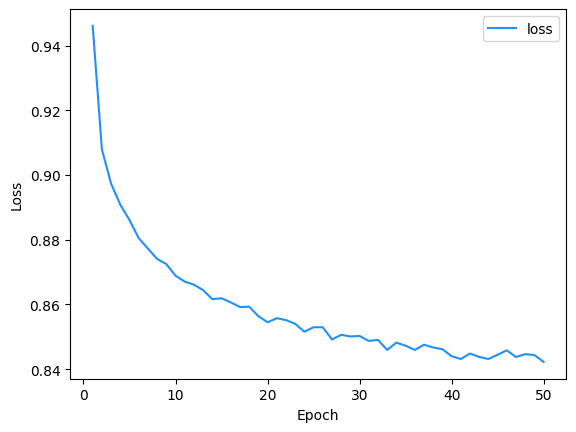

In [58]:
lr_final = 0.0001
gamma_final = 10
epoch_final = 50

model = SVM(gamma_final).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr_final)

model.train()

hist_final = train(train_dl_final, model, loss_fn, optimizer, epoch_final)
plt.plot(range(1, epoch_final+1), hist_final, 'dodgerblue', label='loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig('plot/fig6_train_all.png', dpi=200, bbox_inches='tight')


In [59]:
acc, los = evaluation(model, test_dl_final)

print(f"Accuracy : {acc:.2f}%")
print(f"Average Loss : {los:.5f}")

Accuracy : 62.30%
Average Loss : 0.87424
